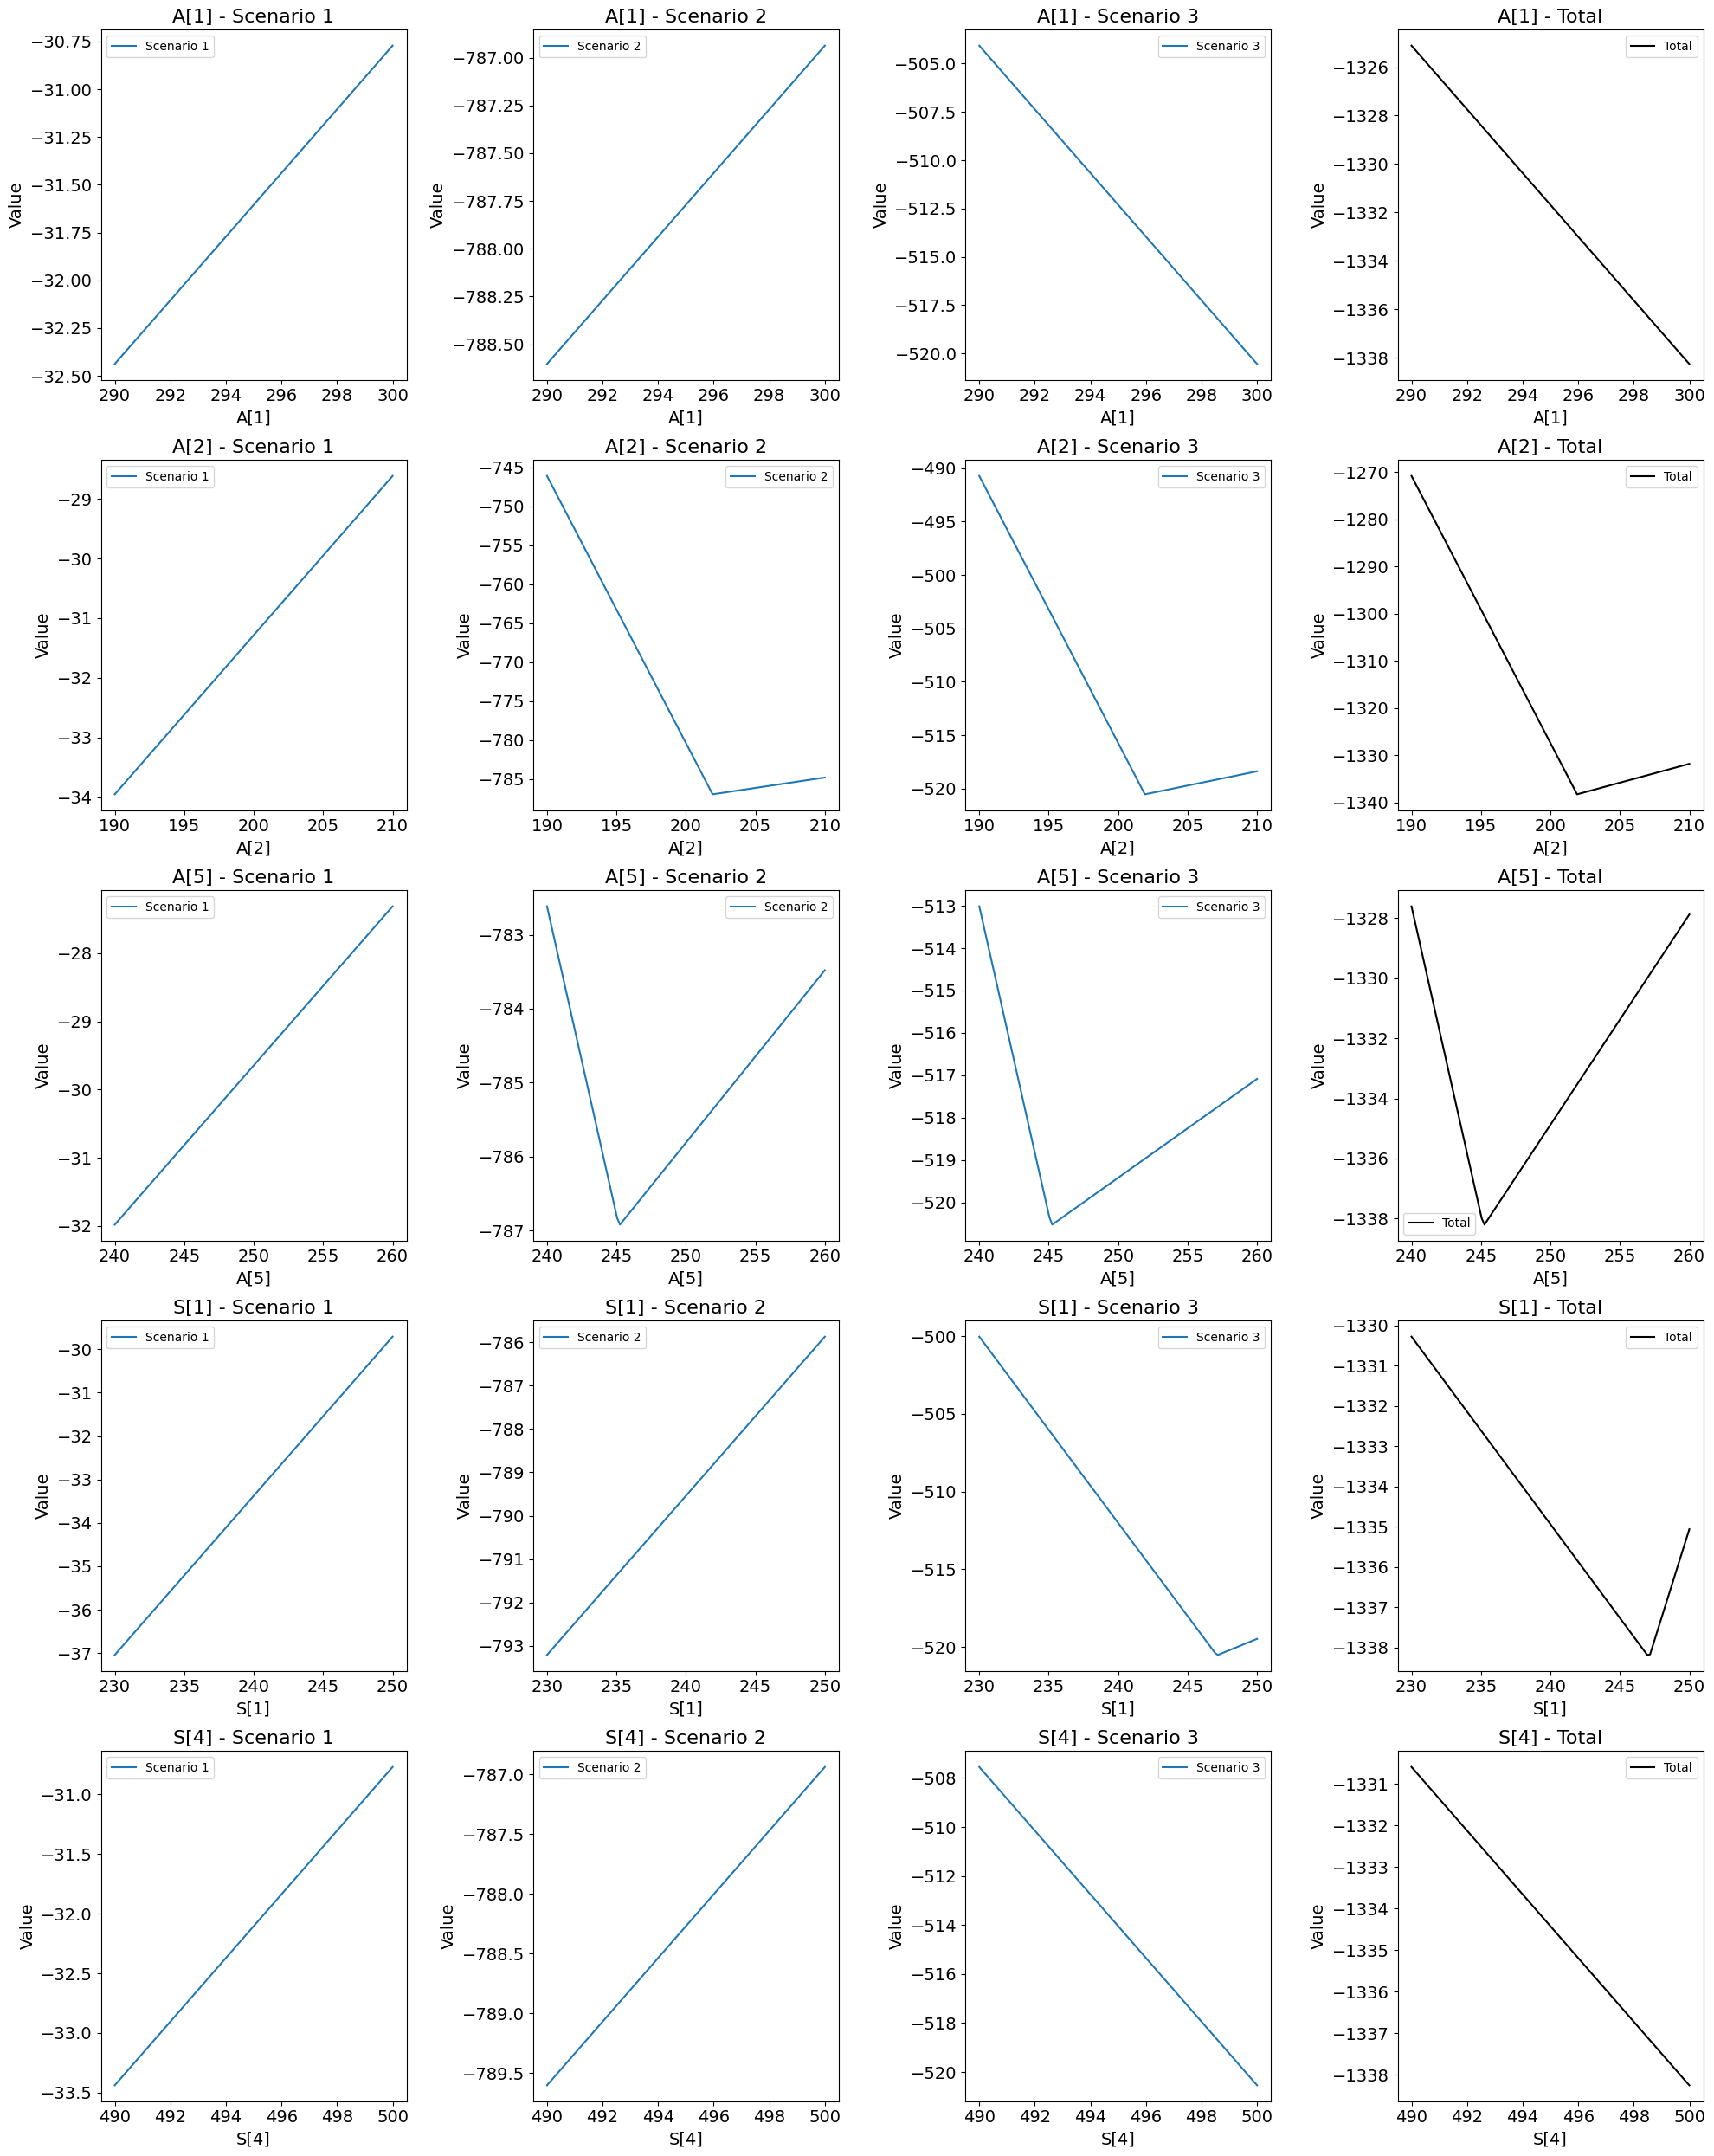

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from pyomo.opt import SolverFactory, TerminationCondition
from src.analyses.value_function import ValueFunction
from src.analyses.convergence_analysis import HausdorffAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from scipy.optimize import curve_fit
from NSPLIB.src.instances.pooling_contract_selection.pooling import const_model
import copy
# Constants
pooling_obj = -1338.2471283376406
pooling_sol = {
    'A[1]': 300.0, 'A[2]': 201.92127476313524, 'A[3]': 0.0, 'A[4]': 0.0, 'A[5]': 245.18105081826008,
    'S[1]': 247.10232558139526, 'S[2]': 0.0, 'S[3]': 0.0, 'S[4]': 500.0
}

pooling_y_bound = {
    'A[1]': [0, 300], 'A[2]': [0, 250], 'A[3]': [0, 0], 'A[4]': [0, 0], 'A[5]': [0, 300],
    'S[1]': [0, 400], 'S[2]': [0, 0], 'S[3]': [0, 0], 'S[4]': [0, 500]
}
pooling_y_bound = {
    'A[1]': [290, 300], 'A[2]': [190, 210], 'A[3]': [0, 0], 'A[4]': [0, 0], 'A[5]': [240, 260],
    'S[1]': [230, 250], 'S[2]': [0, 0], 'S[3]': [0, 0], 'S[4]': [490, 500]
}
# Build model
sto_m = const_model()
m = CaoZavalaModel.from_sto_m(sto_m)
m.build()

# Fix binary variables
binary_ys = ['lambd[1]', 'lambd[2]', 'lambd[3]', 'lambd[4]', 'lambd[5]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]']
binary_y_val = {y: 0 for y in binary_ys}
binary_y_val['lambd[1]'] = 1
binary_y_val['lambd[2]'] = 1
binary_y_val['lambd[5]'] = 1
binary_y_val['theta[1]'] = 1
binary_y_val['theta[4]'] = 1
m.fix_binary_y(binary_y_val)

v_f= ValueFunction(m,solver="baron")
y_dimension = {'A[1]':{}, 'A[2]':{}, 'A[5]':{},'S[1]':{}, 'S[4]':{}}
steps=100
for y in y_dimension.keys():
    v_f.calc_1D(idx=y, y_val_fix=copy.deepcopy(pooling_sol),
                    interval=pooling_y_bound[y], step=steps)
    for s in m.scenarios:
        y_dimension[y][s] = v_f.value_func[s]
    y_dimension[y]['total'] = v_f.total_value_func


fig, axs = plt.subplots(
    nrows=len(y_dimension), 
    ncols=len(m.scenarios) + 1, 
    figsize=(5 * (len(m.scenarios) + 1), 5 * len(y_dimension))
)
for row_idx, (y_key, y_data) in enumerate(y_dimension.items()):
    for col_idx, s in enumerate(m.scenarios):
        ax = axs[row_idx, col_idx] if len(y_dimension) > 1 else axs[col_idx]
        ax.plot(
            np.linspace(*pooling_y_bound[y_key], steps), 
            y_data[s], 
            label=f"Scenario {s}"
        )
        ax.set_title(f"{y_key} - Scenario {s}", fontsize=16)
        ax.set_xlabel(y_key, fontsize=14)
        ax.set_ylabel("Value", fontsize=14)
        ax.tick_params(axis='both', labelsize=14)
        ax.legend()
    # Plot total in the last column
    ax = axs[row_idx, -1] if len(y_dimension) > 1 else axs[-1]
    ax.plot(
        np.linspace(*pooling_y_bound[y_key], steps), 
        y_data['total'], 
        label="Total", color='black'
    )
    ax.set_title(f"{y_key} - Total", fontsize=16)
    ax.set_xlabel(y_key, fontsize=14)
    ax.set_ylabel("Value", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    ax.legend()

plt.tight_layout()
plt.show()